In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# to get weekly info:footballdb.com/teams/index.html + boxscore
# update weather (not consider weather so far)
# for easier access for receive & tot & sack: https://www.espn.com/nfl/boxscore/_/gameId/401437761

## df_final
# websites:https://www.rotowire.com/football/lineups.php (just to check QB)
# to predict final score:https://www.footballdb.com/teams/index.html
# avg penalties:https://www.nflpenalties.com/

# to get more data just for the patterns between parameters, can use last years data.

In [ ]:
# a function for multi QB ratings
def rating(att,com,yard,td,inter):
    r1=round((com/att*100-30)*.05,2)
    r2=round((yard/att-3)*.25,2)
    r3=round(td/att*20,2)
    r4=round(2.375-inter/att*25,2)
    if r1>0 and r2>0:
        return round((r1+r2+r3+r4)*100/6,1)
    else: 
        return 'not none-negative'
#rating(47,35,353,3,1)

In [ ]:
rating(40,27,295,2,4)

In [27]:
# all df is all set with oppo and dif
df_1=pd.read_csv('nfl collection by hand+function .csv')
df_2021=pd.read_csv('nfl w9-16 2021.csv')
df_w7_for_real=pd.read_csv('df_w7_for_real.csv')
df_w8_for_real=pd.read_csv('df_w8_for_real.csv')
df_w9_for_real=pd.read_csv('df_w9_for_real.csv')

In [ ]:
#df_w7_for_real.shape,df_w8_for_real.shape,df_w9_for_real.shape

In [28]:
df=pd.concat([df_1,df_2021,df_w7_for_real,df_w8_for_real,df_w9_for_real],ignore_index=True)
df=df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
print(df.shape)

# lets get the turnover info
df['turnover']=df['fum_lost']+df['oppo_inn']
turnover=df['turnover']
sample_len=len(df['passing'])
oppo_turnover=[0]*sample_len
for i in range(0,sample_len,2):
    oppo_turnover[i]=turnover[i+1]
    oppo_turnover[i+1]=turnover[i]
df['oppo_turnover']=oppo_turnover
df['turnover_dif']=df['turnover']-df['oppo_turnover']

df.tail()

(624, 16)


,div?,home?,passing,rush,receive,kick,fumble,fum_lost,score,kicker_ratio,time,oppo_tot,oppo_sack,oppo_inn,pen_dif,pen_yard_dif,turnover,oppo_turnover,turnover_dif
619,0,1,79.7,2.5,7.8,10,0,0,16,0.8,2,80,1,0,3,2,0,0,0
620,0,0,49.0,5.9,16.0,5,0,0,17,1.0,2,57,3,0,-2,-18,0,1,-1
621,0,1,80.9,4.1,10.4,6,0,0,20,0.5,2,91,4,1,2,18,1,0,1
622,0,0,87.9,4.7,11.1,9,1,0,27,1.0,2,63,3,0,0,-9,0,1,-1
623,0,1,85.8,3.2,11.2,7,0,0,13,1.0,2,47,4,1,0,9,1,0,1


In [ ]:
#df_1.columns,df_2021.columns,df_w7_for_real.columns

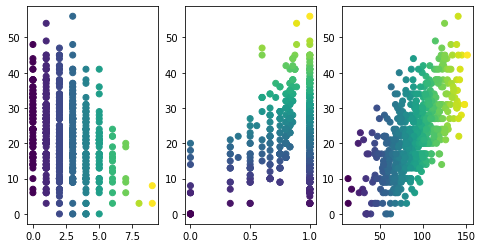

In [29]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(131)
plt.scatter(df['oppo_sack'],df['score'],c=df['oppo_sack'])
ax=fig.add_subplot(132)
plt.scatter(df['kicker_ratio'],df['score'],c=df['score'])
ax=fig.add_subplot(133)
plt.scatter(df['passing'],df['score'],c=df['passing'])
plt.show()

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate   
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

X=df.drop('score',axis=1)
y=df['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
##### copy from  30  Exercise 4-9 solution
# during every random split on cross_validation,
# we wanna use pipeline on every random different split,
# so we need to rewrite custom_cross_validate
from sklearn.base import clone
pipe = Pipeline([('sscaler', StandardScaler())])

def custom_cross_validate(est,X,y,cv=5,pipeline=None):
    result={'train_score':[],
           'test_score':[],
           'estimator':[]}
    for i in range(cv):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)   
        # no random_state for splitting
        
        if pipeline is not None:
            pipe_clone=clone(pipe)
            X_train=pipe_clone.fit_transform(X_train)
            X_val=pipe_clone.transform(X_val)

        est_clone=clone(est)                               
        est_clone.fit(X_train,y_train)
        result['train_score'].append(est_clone.score(X_train,y_train))
        result['test_score'].append(est_clone.score(X_val,y_val))
        result['estimator'].append(est_clone)
    return result

In [32]:
def plotCVResult(cv_res,names):
    fig=plt.figure(figsize=(20,10))
    for i in range(len(names)):
        name=names[i]
        df_reg=pd.DataFrame(cv_res[i])

        ax=fig.add_subplot(2,5,i+1)
        df_reg[['train_score','test_score']].plot(ax=ax)
        ax.set_xlabel('iratation')
        ax.set_ylabel('R2 score')
        ax.set_ylim(0,1)
        ax.set_title(str(name)+' avg test score '+str(round(df_reg.loc[df_reg['test_score']>0]['test_score'].mean(),2)))
    plt.legend()
    plt.show()    

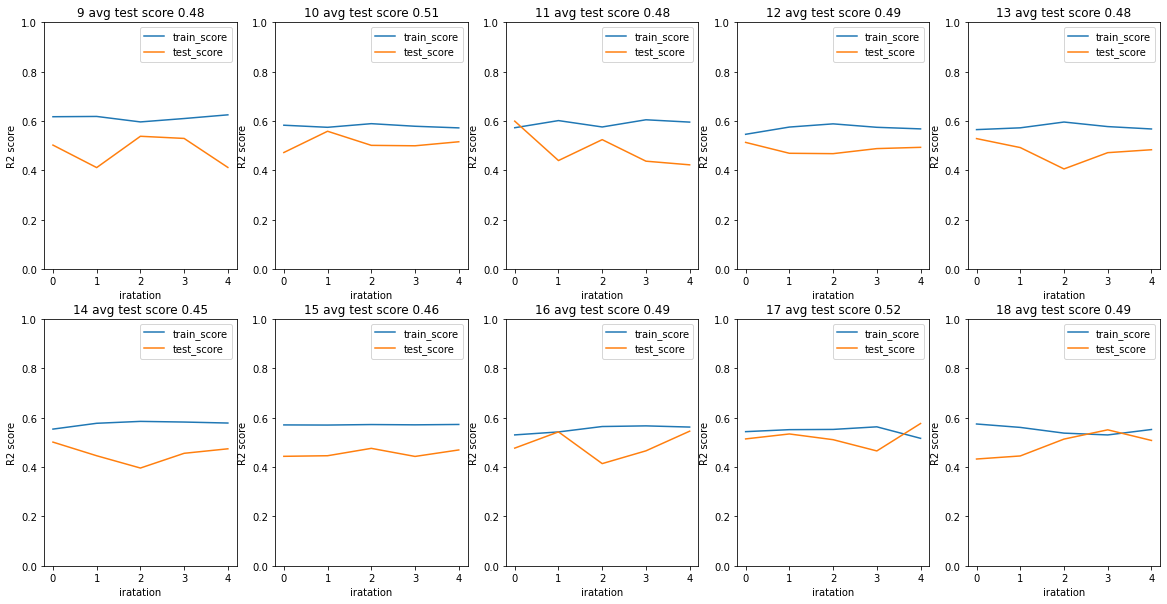

In [33]:
from sklearn.neighbors import KNeighborsRegressor
N_neighbors=range(9,19)
cv_knn_res=[]
for n_neighbors in N_neighbors:
    cv_knn_res.append(custom_cross_validate(KNeighborsRegressor(n_neighbors=n_neighbors),
                  X_train,y_train,cv=5,pipeline=pipe))
plotCVResult(cv_knn_res,N_neighbors)   

In [34]:
ind=np.argmax(cv_knn_res[0]['test_score'])
knn=cv_knn_res[0]['estimator'][ind]

Linear Regression NoneZeroWeight 18.0
Lasso Reg NoneZeroWeight 6.6
Ridge Reg NoneZeroWeight 18.0
Elastic Net NoneZeroWeight 12.0


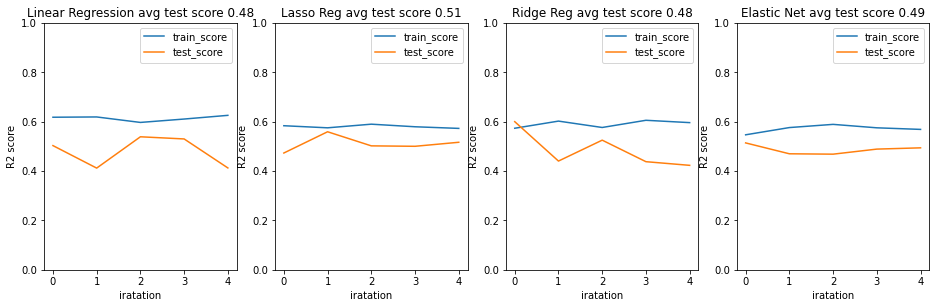

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

cv_result=[]
names=['Linear Regression','Lasso Reg','Ridge Reg','Elastic Net']
for model in [LinearRegression(),Lasso(), Ridge(),ElasticNet(l1_ratio=0.6)]:
    cv_result.append(custom_cross_validate(model,X_train,y_train,cv=5,pipeline=pipe))
    
def getNoneZeroWeight(est):
    return len(est.coef_[est.coef_!=0])

for i in range(4):
    df_reg=pd.DataFrame(cv_result[i])
    df_reg['NoneZeroWeight']=df_reg['estimator'].apply(getNoneZeroWeight)
    print(names[i]+' NoneZeroWeight '+str(df_reg['NoneZeroWeight'].mean()))
    
plotCVResult(cv_knn_res,names)
# 0.7--0.52
# Lasso works as feature selection, is the least overfitting with the best test_score, shows much more consistant perormance
# the optimization technique: coordinate descent or gradient descent.
# lasso takes a little longer to train, the differences arise due to coordinate descent, the same as elastic_net
# linear and ridge Regression use gradient descent

In [36]:
cv_result[1]['estimator'][0].coef_

array([-0.        ,  0.        ,  4.32704666,  0.86345622,  0.84304057,
        2.61666661, -0.        , -0.09574401,  0.        , -0.        ,
        0.        , -0.27875024,  0.        , -0.        , -0.        ,
       -0.        ,  0.58861517, -0.        ])

In [37]:
ind=np.argmax(cv_result[0]['test_score'])
linear=cv_result[0]['estimator'][ind]

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4353.975113355468, tolerance: 2.9166351097178684
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4088.965205850979, tolerance: 2.7832351097178685
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4343.809645338223, tolerance: 2.9159335423197494
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1315.1415065444753, tolerance: 2.9166351097178684
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1357.1796711023921, tolerance: 2.7832351097178685
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1376.9170022890057, tolerance: 2.9159335423197494
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergence

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1731.0682311464302, tolerance: 2.7832351097178685
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878.9342702012455, tolerance: 2.9159335423197494
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1629.7956229360002, tolerance: 2.698551724137931
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4352.0110943112295, tolerance: 2.9159335423197494
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3769.4357033084593, tolerance: 2.698551724137931
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4061.9210315290447, tolerance: 3.05419875
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146.75145947089004, tolerance: 2.9166351097178684
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4433.894582115529, tolerance: 2.9166351097178684
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4164.551109888728, tolerance: 2.7832351097178685
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1901.778699423559, tolerance: 2.907902194357367
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2320.861041973312, tolerance: 3.136408777429467
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1812.6545664014166, tolerance: 3.0679931034482757
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4524.668629321711, tolerance: 3.0679931034482757
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4964.170652941837, tolerance: 3.161408777429467
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4664.928402492921, tolerance: 3.0307887499999997
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414.5364523533708, tolerance: 3.0679931034482757
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1523.9822713130297, tolerance: 3.161408777429467
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 207.64530076980554, tolerance: 3.0307887499999997
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.14931495960172, tolerance: 2.907902194357367
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.44252175274778, tolerance: 3.136408777429467
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.3878507252939, tolerance: 3.0679931034482757
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4167.718436826971, tolerance: 3.1689454545454545
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3920.0174665006393, tolerance: 3.153684639498433
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4500.481812470585, tolerance: 3.1749724137931037
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1479.84327059919, tolerance: 3.1689454545454545
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1305.6508646223442, tolerance: 3.153684639498433
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1484.9097992200864, tolerance: 3.1749724137931037
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 694.5410653893196, tolerance: 3.1749724137931037
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 873.4967633532287, tolerance: 2.9763550000000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1727.4874220462575, tolerance: 3.2379573667711603
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1379.402691449096, tolerance: 3.2379573667711603
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 979.6717275051324, tolerance: 3.1689454545454545
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.5989954682618, tolerance: 3.153684639498433
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8223.218166919414, tolerance: 3.1689454545454545
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8391.919538613345, tolerance: 3.153684639498433
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8802.17267755606, tolerance: 3.1749724137931037
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3200.3928078430718, tolerance: 3.046841379310345
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3292.2635956303434, tolerance: 3.1392846394984324
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3232.742777608853, tolerance: 2.91678934169279
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1429.5634728111372, tolerance: 3.046841379310345
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1319.7163253525755, tolerance: 3.1392846394984324
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1292.4733072732301, tolerance: 2.91678934169279
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5584.657135967525, tolerance: 3.293481504702194
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5184.10688314256, tolerance: 3.046841379310345
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5270.618840221008, tolerance: 3.1392846394984324
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1309.2522258351555, tolerance: 3.094643260188088
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1647.6116701002084, tolerance: 3.1505746875000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1173.4105768352092, tolerance: 2.6834438871473356
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 884.190692240677, tolerance: 3.066515987460815
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2056.9498475572095, tolerance: 3.164407523510972
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.2465018887888, tolerance: 3.094643260188088
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4053.3506631935093, tolerance: 2.6834438871473356
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4389.680852020556, tolerance: 3.066515987460815
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4256.498970395132, tolerance: 3.164407523510972
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148.03763598502883, tolerance: 3.164407523510972
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.472944445446956, tolerance: 3.094643260188088
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4126.564067338885, tolerance: 2.6834438871473356
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

[{'train_score': [0.7079945666946373, 0.6983459853240933, 0.7300626304355915, 0.7111458577500209, 0.7022684118760927], 'test_score': [0.6724421275284048, 0.6952803666635303, 0.5810816003084065, 0.6474997056481353, 0.707491762016226], 'estimator': [GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                      0.8]}), GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                      0.8]}), GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                      0.8]}), GridSearchCV(estimator=ElasticNet(),
             param_gri

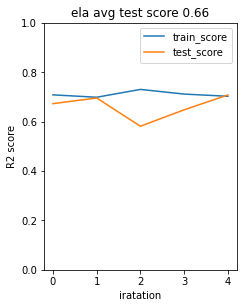

In [38]:
parameters = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1], \
              'l1_ratio':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]}
ela=ElasticNet()
cv_ela_res=[]
cv_ela_res.append(custom_cross_validate(GridSearchCV(ela, param_grid=parameters),
                  X_train,y_train,cv=5,pipeline=pipe))
print(cv_ela_res)
#GridSearchCV(ela, param_grid=parameters).get_params(deep=True)
ind=np.argmax(cv_ela_res[0]['test_score'])
ela=cv_ela_res[0]['estimator'][ind]
plotCVResult(cv_ela_res,names=['ela'])

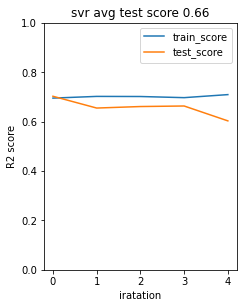

In [39]:
# This is the process of running different Regressors, but with bad results.
# So we picked KNeighborsRegressor and LinearRegression.

from sklearn.svm import SVR                    
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'C':[0.05,0.1,0.2,0.5,1]}
svr=SVR()
cv_svr_res=[]
cv_svr_res.append(custom_cross_validate(GridSearchCV(svr, param_grid=parameters),
                  X_train,y_train,cv=5,pipeline=pipe))
plotCVResult(cv_svr_res,names=['svr'])
ind=np.argmax(cv_svr_res[0]['test_score'])
svr=cv_svr_res[0]['estimator'][ind]

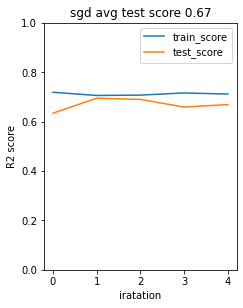

In [40]:
from sklearn.tree import DecisionTreeRegressor 
dtr=DecisionTreeRegressor()
cv_dtr_res=[]
cv_dtr_res.append(custom_cross_validate(dtr,
                  X_train,y_train,cv=5,pipeline=pipe))
#plotCVResult(cv_dtr_res,names=['dtr']) # dtr is no good here

from sklearn.linear_model import SGDRegressor   
sgd=SGDRegressor()
cv_sgd_res=[]
cv_sgd_res.append(custom_cross_validate(sgd,
                  X_train,y_train,cv=5,pipeline=pipe))
plotCVResult(cv_sgd_res,names=['sgd'])

ind=np.argmax(cv_sgd_res[0]['test_score'])
sgd=cv_sgd_res[0]['estimator'][ind]

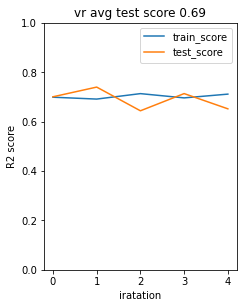

In [44]:
# lets try ensemble knn & ElasticNet
from sklearn.ensemble import VotingRegressor  
vr = VotingRegressor([('svr',svr), ('ela',sgd)])
cv_vr_res=[]
cv_vr_res.append(custom_cross_validate(vr,
                  X_train,y_train,cv=5,pipeline=pipe))
plotCVResult(cv_vr_res,names=['vr'])

ind=np.argmax(cv_vr_res[0]['test_score'])
vr=cv_vr_res[0]['estimator'][ind]

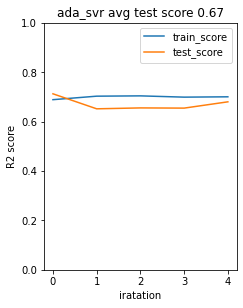

In [45]:
# This is the process of using different ensembles, but with bad results.
# So we picked VotingRegressor.

from sklearn.ensemble import AdaBoostRegressor
ada_reg=AdaBoostRegressor(base_estimator=svr, learning_rate=0.00001)
cv_ada_res=[]
cv_ada_res.append(custom_cross_validate(ada_reg,
                  X_train,y_train,cv=5,pipeline=pipe))
plotCVResult(cv_ada_res,names=['ada_svr'])
ind=np.argmax(cv_ada_res[0]['test_score'])
ada_svr=cv_ada_res[0]['estimator'][ind]

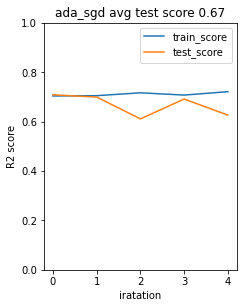

In [46]:
ada_reg=AdaBoostRegressor(base_estimator=sgd, learning_rate=0.00001)
cv_ada_res=[]
cv_ada_res.append(custom_cross_validate(ada_reg,
                  X_train,y_train,cv=5,pipeline=pipe))
plotCVResult(cv_ada_res,names=['ada_sgd'])
ind=np.argmax(cv_ada_res[0]['test_score'])
ada_sgd=cv_ada_res[0]['estimator'][ind]

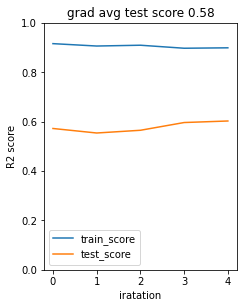

In [47]:
from sklearn.ensemble import GradientBoostingRegressor  
grad_reg=GradientBoostingRegressor()
cv_grad_res=[]
cv_grad_res.append(custom_cross_validate(grad_reg,
                  X_train,y_train,cv=5,pipeline=pipe))
plotCVResult(cv_grad_res,names=['grad'])
ind=np.argmax(cv_grad_res[0]['test_score'])
grad=cv_grad_res[0]['estimator'][ind] 
# grad is no good here

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4683.649225916701, tolerance: 3.19950407523511
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4614.217305633919, tolerance: 3.197358620689655
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4429.485624260388, tolerance: 2.9759260188087775
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1288.248962934148, tolerance: 2.9759260188087775
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1389.4277260818562, tolerance: 3.2418927899686527
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1330.571355661259, tolerance: 3.12772
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obje

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1259.6744776704572, tolerance: 2.9759260188087775
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1383.5568734731519, tolerance: 3.2418927899686527
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1503.8009763924747, tolerance: 3.12772
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Ob

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.2327982106035, tolerance: 3.2418927899686527
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.72240162925209, tolerance: 3.12772
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.830994739966627, tolerance: 3.19950407523511
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objecti

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2947.9502895575642, tolerance: 2.5044859375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2090.9899152216276, tolerance: 2.6549584313725494
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1992.839916262616, tolerance: 2.2966329411764708
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2463.4984794489947, tolerance: 2.2966329411764708
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2518.42407832741, tolerance: 2.668552941176471
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2514.86564057983, tolerance: 2.6579466666666667
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3655.197358304109, tolerance: 2.6579466666666667
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3745.884435093812, tolerance: 2.5044859375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 681.5784012762379, tolerance: 2.6549584313725494
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4505.643302114163, tolerance: 2.6549584313725494
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4156.1283424619405, tolerance: 2.2966329411764708
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4371.834575857911, tolerance: 2.668552941176471
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2732.486900671306, tolerance: 2.5132609375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011.5535085370054, tolerance: 2.6096141176470593
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1610.7378486597822, tolerance: 2.3397984313725493
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3638.8505924692063, tolerance: 2.671252549019608
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3580.9434365464417, tolerance: 2.644210196078432
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3641.355622204414, tolerance: 2.5132609375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3655.9034640760933, tolerance: 2.644210196078432
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3712.167007033204, tolerance: 2.5132609375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4477.030724463833, tolerance: 2.6096141176470593
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 952.2417717489152, tolerance: 2.268775
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1053.170741556702, tolerance: 2.3838407843137257
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 887.9474361463158, tolerance: 2.4803749019607846
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obje

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1205.5735464622353, tolerance: 2.4428901960784315
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1239.9886979457383, tolerance: 2.268775
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.81416741913654, tolerance: 2.4803749019607846
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Ob

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.88972791467677, tolerance: 2.3130235294117645
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199.7607086854241, tolerance: 2.4428901960784315
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256.1779626683574, tolerance: 2.268775
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obj

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4139.75753621436, tolerance: 2.3838407843137257
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4267.630044085921, tolerance: 2.4803749019607846
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3922.6232081140906, tolerance: 2.3130235294117645
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2693.9503463297024, tolerance: 2.560375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011.6704271527515, tolerance: 2.6540407843137257
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1843.640703008355, tolerance: 2.7326549019607844
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Ob

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3244.68908320863, tolerance: 2.3760101960784317
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3627.1188512252415, tolerance: 2.6242901960784315
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3470.713539857687, tolerance: 2.560375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obje

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4260.540424967954, tolerance: 2.6540407843137257
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4358.145704844343, tolerance: 2.7326549019607844
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3856.223723002129, tolerance: 2.3760101960784317
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1024.4840496760394, tolerance: 2.4558859375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1036.6117800593006, tolerance: 2.589824609375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3644.70183325433, tolerance: 2.5349359375000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obj

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1010.9496634297593, tolerance: 2.4558859375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1083.1805320043381, tolerance: 2.589824609375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1056.2011372836278, tolerance: 2.5349359375000002
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.21858636555771, tolerance: 2.589824609375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.595190942744921, tolerance: 2.6326734375000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.702422644672879, tolerance: 2.284458984375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Ob

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1772.5854305783678, tolerance: 3.046619435736677
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1491.1004461243438, tolerance: 2.969684639498433
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845.952685070445, tolerance: 3.0108
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Object

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2915.1883577126473, tolerance: 3.0108
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1208.0945748109125, tolerance: 2.769747335423198
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 936.7323870020828, tolerance: 2.733807523510972
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Object

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4631.938306564212, tolerance: 3.0108
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1512.126765790701, tolerance: 2.769747335423198
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1020.1624361875733, tolerance: 2.733807523510972
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objecti

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4207.000707640073, tolerance: 2.769747335423198
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4127.393568782885, tolerance: 2.733807523510972
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4669.88864197451, tolerance: 3.046619435736677
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1253.7943049404696, tolerance: 2.106652549019608
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1777.7237978962364, tolerance: 2.196833725490196
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1575.0716844962485, tolerance: 2.3276141176470593
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1691.7861401724592, tolerance: 2.3276141176470593
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1484.569425653819, tolerance: 2.240786666666667
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2304.3538878993036, tolerance: 2.205327734375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3474.602881432991, tolerance: 2.196833725490196
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3418.572041182835, tolerance: 2.3276141176470593
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3063.318106454649, tolerance: 2.240786666666667
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2931.6185985775533, tolerance: 2.106652549019608
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3527.1444978001077, tolerance: 2.196833725490196
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3479.25399665886, tolerance: 2.3276141176470593
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1375.1047737972922, tolerance: 2.250690196078432
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1414.8588069743469, tolerance: 2.2908807843137255
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1165.794022539983, tolerance: 2.20112
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obje

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1474.5182966786747, tolerance: 2.250690196078432
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1513.9663561701032, tolerance: 2.2908807843137255
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1672.5022697429781, tolerance: 2.20112
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obj

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431.78715188968636, tolerance: 2.1682
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182.1492673016346, tolerance: 2.0194407843137254
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.57727217424872, tolerance: 2.250690196078432
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objec

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5988.341595798009, tolerance: 2.20112
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6320.4930308615285, tolerance: 2.1682
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3556.4475448124704, tolerance: 2.3274807843137255
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did n

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2638.1321912057265, tolerance: 2.5379231372549027
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2499.7911955540803, tolerance: 2.3170101960784315
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2620.5550301307676, tolerance: 2.517123137254902
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367.7487674885024, tolerance: 2.5379231372549027
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369.9270407723343, tolerance: 2.3170101960784315
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351.6645978074912, tolerance: 2.517123137254902
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.0381316493731, tolerance: 2.4820808593750003
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.40354783352086, tolerance: 2.3274807843137255
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.95329090155792, tolerance: 2.5379231372549027
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1064.0019695791284, tolerance: 2.4585937254901964
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1074.9509499677247, tolerance: 2.16928
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1311.845427619167, tolerance: 2.587672941176471
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obje

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1763.9278544619197, tolerance: 2.40399375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298.0103925710782, tolerance: 2.255563137254902
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.05326325074748, tolerance: 2.4585937254901964
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163.0202828836018, tolerance: 2.4585937254901964
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.54404200193767, tolerance: 2.16928
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355.8330534169909, tolerance: 2.587672941176471
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objec

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2239.695190473538, tolerance: 2.2101
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2693.0897394876756, tolerance: 2.60969375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2259.4410407287965, tolerance: 2.4225484375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not 

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2693.199596268745, tolerance: 2.4225484375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2312.2632190936365, tolerance: 2.298375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1811.2201643792068, tolerance: 2.4985609375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did 

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4063.9890036962724, tolerance: 2.60969375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3464.2398038010765, tolerance: 2.4225484375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1547.507163394183, tolerance: 2.298375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did no

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4127.358770077263, tolerance: 2.60969375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3524.962580314704, tolerance: 2.4225484375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4125.7128454227595, tolerance: 2.298375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1520.2117555666505, tolerance: 3.1444557993730404
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1329.4804272896467, tolerance: 2.9316996865203766
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1308.7839414851023, tolerance: 2.938336677115988
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1485.085245742774, tolerance: 2.9316996865203766
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.23533797574873, tolerance: 2.938336677115988
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1597.5112092255808, tolerance: 3.1566351097178686
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206.58189646721257, tolerance: 3.1566351097178686
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.16674707489437, tolerance: 3.2915846875
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.71410084230592, tolerance: 3.1444557993730404
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2127.0825694305086, tolerance: 2.6318329411764707
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1864.2061774756662, tolerance: 2.659152734375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1690.7816523894521, tolerance: 2.440856470588235
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2346.2975583411235, tolerance: 2.659152734375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1975.1271399227662, tolerance: 2.440856470588235
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1700.20966358846, tolerance: 2.3068917647058824
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3574.7969678620325, tolerance: 2.5273396078431376
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3487.942924732431, tolerance: 2.6318329411764707
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3418.5927100196195, tolerance: 2.659152734375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3481.160374117079, tolerance: 2.659152734375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4134.363780717557, tolerance: 2.440856470588235
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3702.935087432502, tolerance: 2.3068917647058824
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1059.714026852706, tolerance: 2.3089749019607844
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 963.9650629641983, tolerance: 2.2300964705882356
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1149.6619409912537, tolerance: 2.314503529411765
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340.3540650248069, tolerance: 2.2300964705882356
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1112.8421641843356, tolerance: 2.314503529411765
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191.7255527954585, tolerance: 2.4188431372549024
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.47892074944502, tolerance: 2.314503529411765
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.890096050518878, tolerance: 2.4188431372549024
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3502.6171721779638, tolerance: 2.3089749019607844
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1078.3967055878388, tolerance: 2.1576431372549023
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 992.8075154118255, tolerance: 2.4338
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1053.3794852476167, tolerance: 2.451040234375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objectiv

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.694309808315666, tolerance: 2.4338
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266.6885523511637, tolerance: 2.451040234375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1129.5820402572535, tolerance: 2.3145435294117647
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.40828276614593, tolerance: 2.3145435294117647
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.162724974532466, tolerance: 2.393367058823529
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.56180782838419, tolerance: 2.1576431372549023
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2103.56286380234, tolerance: 2.6832784313725493
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1904.9719335625523, tolerance: 2.6708234375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1777.3163111205313, tolerance: 2.5331231372549023
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2307.9261070243238, tolerance: 2.6832784313725493
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2356.674783596983, tolerance: 2.6708234375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2059.3579574539563, tolerance: 2.5331231372549023
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3645.440323484576, tolerance: 2.6832784313725493
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3387.5840538777784, tolerance: 2.6708234375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 879.118289681368, tolerance: 2.5331231372549023
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4067.660127326617, tolerance: 2.5331231372549023
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4392.929940519297, tolerance: 2.613690196078432
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3581.516951355117, tolerance: 2.122563137254902
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 411.2240316231964, tolerance: 2.2543484375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 647.4116502673105, tolerance: 2.7645214843750003
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1010.4229481684774, tolerance: 2.725575
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195.680352390199, tolerance: 2.748999609375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.78802975600047, tolerance: 2.2543484375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248.6364216244774, tolerance: 2.7645214843750003
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obje

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3234.114037027198, tolerance: 3.0539871874999998
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2596.08509854779, tolerance: 3.1581159874608153
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2576.6601264072756, tolerance: 3.043388087774295
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1333.0090744274098, tolerance: 3.043388087774295
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1267.4650383625035, tolerance: 3.2960231974921625
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1372.494063553272, tolerance: 3.3206746081504703
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.06629817940757, tolerance: 3.043388087774295
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1209.8337728181655, tolerance: 3.2960231974921625
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1386.3757440294912, tolerance: 3.3206746081504703
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.397589248152144, tolerance: 3.1581159874608153
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.57836691694138, tolerance: 3.043388087774295
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.49318794991723, tolerance: 3.2960231974921625
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2113.7124706531777, tolerance: 2.6922964705882353
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2149.454136534791, tolerance: 2.583143529411765
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1981.092292170006, tolerance: 2.38174375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Ob

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2544.06025013918, tolerance: 2.583143529411765
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2516.7844793976647, tolerance: 2.38174375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1212.418736808871, tolerance: 2.415174117647059
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obje

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3745.7751549505224, tolerance: 2.38174375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 622.4462645550329, tolerance: 2.415174117647059
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489.32429204441996, tolerance: 2.5554117647058825
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4263.41236266678, tolerance: 2.415174117647059
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4186.185494629594, tolerance: 2.5554117647058825
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4357.256630850741, tolerance: 2.6922964705882353
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2341.8629960724998, tolerance: 2.4640807843137256
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2332.167842084321, tolerance: 2.5775866666666665
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2245.1907089896295, tolerance: 2.4693749019607845
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321.48673902303926, tolerance: 2.4640807843137256
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.99769806841869, tolerance: 2.5775866666666665
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312.6165192340004, tolerance: 2.4693749019607845
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.820017906737121, tolerance: 2.3896337254901963
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.377693433681998, tolerance: 2.4640807843137256
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.481826584677947, tolerance: 2.5775866666666665
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1779.645532427533, tolerance: 2.6452807843137256
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1697.8054515220183, tolerance: 2.6433866666666668
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1675.4285763885507, tolerance: 2.648633725490196
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1425.4493448797482, tolerance: 2.648633725490196
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1944.272538241834, tolerance: 2.719763137254902
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1996.83583743503, tolerance: 2.5200839843750003
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3500.800108686843, tolerance: 2.5200839843750003
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 699.8887239509595, tolerance: 2.6452807843137256
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1002.3939198132302, tolerance: 2.6433866666666668
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4270.49441762268, tolerance: 2.6452807843137256
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4090.7322099373696, tolerance: 2.6433866666666668
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3777.475495584684, tolerance: 2.648633725490196
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2306.353114251437, tolerance: 2.570078431372549
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2585.265897470831, tolerance: 2.8215741176470592
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2494.3768818198796, tolerance: 2.545
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objecti

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3466.9661310158085, tolerance: 2.8215741176470592
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3495.3812942372783, tolerance: 2.545
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 795.8761338241911, tolerance: 2.6711082352941182
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objec

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4301.518803619732, tolerance: 2.6711082352941182
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4173.621288874409, tolerance: 2.6685584313725492
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3709.059678787594, tolerance: 2.570078431372549
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2668.399023999752, tolerance: 2.551371484375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2688.0172632544436, tolerance: 2.54739375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1380.2438161433338, tolerance: 2.4066609375000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obje

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.4144177994494, tolerance: 2.4027609375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 644.6526887264858, tolerance: 2.300658984375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.7445628998012, tolerance: 2.551371484375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objectiv

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4416.947830569917, tolerance: 2.4066609375000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4283.651426270737, tolerance: 2.4027609375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3799.6592833499103, tolerance: 2.300658984375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obj

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1396.0720078812028, tolerance: 3.1350470219435738
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1343.5417101054254, tolerance: 3.1718652037617554
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1397.550730067634, tolerance: 3.1486721875
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1312.847455363264, tolerance: 3.1350470219435738
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.62456252156244, tolerance: 3.1718652037617554
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1366.7672704192992, tolerance: 3.1486721875
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.16619430179526, tolerance: 3.1718652037617554
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.929949926116024, tolerance: 3.1486721875
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.826168521854015, tolerance: 3.058223197492163
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2428.0942725056434, tolerance: 2.5358996078431373
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2320.535724631769, tolerance: 2.478433725490196
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2134.6845237087564, tolerance: 2.4607749019607845
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2543.7285539478025, tolerance: 2.280210196078431
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2857.53246622707, tolerance: 2.5358996078431373
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2586.166720962257, tolerance: 2.478433725490196
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1018.1331272923226, tolerance: 2.5358996078431373
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277.69827283125505, tolerance: 2.478433725490196
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 899.6779989510255, tolerance: 2.4607749019607845
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3236.8696317564795, tolerance: 2.280210196078431
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3718.209220905668, tolerance: 2.5358996078431373
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3635.5890101273144, tolerance: 2.478433725490196
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 910.0451926827782, tolerance: 2.297563137254902
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.4667858107023, tolerance: 2.4120329411764705
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 997.1797459308787, tolerance: 2.374163137254902
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 984.0471430886769, tolerance: 2.4120329411764705
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.0837470099441, tolerance: 2.374163137254902
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 784.0526009213813, tolerance: 2.3568996078431375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.78916988938272, tolerance: 2.297563137254902
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.07531950192697, tolerance: 2.3568996078431375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3292.755886345311, tolerance: 2.297563137254902
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1154.4425456689314, tolerance: 2.543892549019608
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1402.5000083940186, tolerance: 2.519975
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1085.1334071805345, tolerance: 2.4876337254901966
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Ob

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1376.2741596864694, tolerance: 2.519975
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1210.0003193801904, tolerance: 2.4876337254901966
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1217.482063707499, tolerance: 2.332793725490196
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Obj

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.41299142330172, tolerance: 2.4876337254901966
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.22458803619975, tolerance: 2.332793725490196
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.968708733362291, tolerance: 2.629210196078432
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2069.4342395202693, tolerance: 2.5793858823529416
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2337.2061677009046, tolerance: 2.5854464843750002
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1858.8885286402513, tolerance: 2.5095584313725494
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergence

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2287.9786651318973, tolerance: 2.5793858823529416
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2828.790014778324, tolerance: 2.5854464843750002
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1562.2510221841326, tolerance: 2.5095584313725494
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3622.3959321523207, tolerance: 2.5095584313725494
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3259.730087236486, tolerance: 2.379078431372549
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3879.8905597279672, tolerance: 2.617219607843137
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3328.63352275524, tolerance: 2.379078431372549
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3945.5461431448493, tolerance: 2.617219607843137
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3618.6340275255143, tolerance: 2.5793858823529416
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1073.4497271389214, tolerance: 2.5010734375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1038.5047436143282, tolerance: 2.346715234375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1156.5570739602667, tolerance: 2.6119484375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objecti

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1167.7599886502871, tolerance: 2.575887109375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1066.9098255574531, tolerance: 2.55134375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1034.1772983197284, tolerance: 2.5010734375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective

C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.90302576732847, tolerance: 2.5010734375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.046540002862457, tolerance: 2.346715234375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.53608526599692, tolerance: 2.6119484375
  model = cd_fast.enet_coordinate_descent(
C:\Users\codym\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective

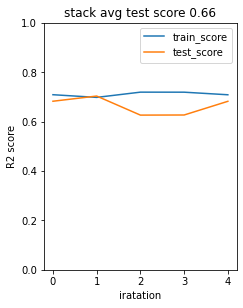

In [48]:
from sklearn.ensemble import StackingRegressor    
estimators = [('svr',ela),('ela', sgd)]
stack_reg = StackingRegressor(estimators=estimators)
cv_stack_res=[]
cv_stack_res.append(custom_cross_validate(stack_reg,
                  X_train,y_train,cv=5,pipeline=pipe))
plotCVResult(cv_stack_res,names=['stack'])
ind=np.argmax(cv_stack_res[0]['test_score'])
stack=cv_stack_res[0]['estimator'][ind]

# now we get the avg data for each team for prediction

In [2]:
# this is the data we need by entering manually.
pen=[4.3,5.6,7.3,5.7,5,5.4,6.4,5,6,5.9,\
    6.4,6.4,5.4,6.8,6.9,6.4,8.8,6.6,5.2,6.3,\
    6.9,6.2,7.1,4,5.8,6.4,5.8,5.4]
pen_yard=[34.4,50.2,62.4,45.9,39.1,36.9,52.6,47.2,46,54.9,\
         51.6,50.4,42.3,53.4,58.4,44.8,75.1,54,43,49.4,\
         52.3,47.4,56.9,38.5,47.8,44.8,55.9,40.5]
home=[0,1,0,0]+[0,1]*12
time=[0]*2+[1]*16+[2]*10
div=[1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1]

In [3]:
from selenium import webdriver  
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec

# way 1: use the whole team avg (use qb rating of way 2)
# so run way 2 first

In [ ]:
#(kick,inn,fum,fum_lost,tot,sack need to /divided_weeks)
# this time, the team is ordered by the WH paper.

In [20]:
# to get rush yard/attempt, receive yard/attempt, kick avg ponits, kicker_ratio,
# avg total of tackles, avg sacks, avg interception, avg fumble and avg fumble_lost
# from footballdb.com
def get_rush_rec_ki_tot_sack_inn_fum(divided_weeks,url):
    driver=webdriver.Chrome(executable_path='\\Users\\codym\\OneDrive\\Desktop\\Accounting\\Data Scientist\\web-scrapping & APIs\\chromedriver')
    driver.get(url)
    
    global rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost
    element= driver.find_elements_by_id("divToggle_R")
    rush.append(float(element[0].text.split('\n')[-2].split(' ')[-5]))
    element= driver.find_elements_by_id("divToggle_C")
    receive.append(float(element[0].text.split('\n')[-2].split(' ')[-7]))
    element= driver.find_elements_by_id("divToggle_K")
    kick.append(float(element[0].text.split('\n')[-2].split(' ')[-1])/divided_weeks)

    kicker_com_fg=int(element[0].text.split('\n')[-2].split(' ')[-8].split('/')[0]) 
    kicker_att_fg=int(element[0].text.split('\n')[-2].split(' ')[-8].split('/')[1])
    kicker_com_xp=int(element[0].text.split('\n')[-2].split(' ')[-9].split('/')[0])
    kicker_att_xp=int(element[0].text.split('\n')[-2].split(' ')[-9].split('/')[1]) 
    kicker_ratio.append((kicker_com_fg+kicker_com_xp)/(kicker_att_fg+kicker_att_xp))
    
    element= driver.find_elements_by_id("divToggle_D")
    tot.append(float(element[0].text.split('\n')[-2].split(' ')[-3])/divided_weeks)
    sack.append(float(element[0].text.split('\n')[-2].split(' ')[-2])/divided_weeks)
    inn.append(float(element[0].text.split('\n')[-2].split(' ')[-10])/divided_weeks)
    
    element= driver.find_elements_by_id("divToggle_M")
    fum.append(float(element[0].text.split('\n')[-2].split(' ')[-8])/divided_weeks)
    fum_lost.append(float(element[0].text.split('\n')[-2].split(' ')[-7])/divided_weeks)
    driver.close()
    return rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost

In [21]:
rush=[]
inn=[]
receive=[]
tot=[]
sack=[]
kick=[]
kicker_ratio=[]
fum=[]
fum_lost=[]

In [22]:
url='https://www.footballdb.com/teams/nfl/atlanta-falcons/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(9,url)
url='https://www.footballdb.com/teams/nfl/carolina-panthers/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(9,url)
url='https://www.footballdb.com/teams/nfl/seattle-seahawks/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(9,url)
url='https://www.footballdb.com/teams/nfl/tampa-bay-buccaneers/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(9,url)
url='https://www.footballdb.com/teams/nfl/minnesota-vikings/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/buffalo-bills/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/detroit-lions/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/chicago-bears/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(9,url)
url='https://www.footballdb.com/teams/nfl/jacksonville-jaguars/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(9,url)
url='https://www.footballdb.com/teams/nfl/kansas-city-chiefs/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)

url='https://www.footballdb.com/teams/nfl/cleveland-browns/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/miami-dolphins/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(9,url)
url='https://www.footballdb.com/teams/nfl/houston-texans/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/new-york-giants/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/new-orleans-saints/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(9,url)
url='https://www.footballdb.com/teams/nfl/pittsburgh-steelers/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/denver-broncos/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/tennessee-titans/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/indianapolis-colts/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(9,url)
url='https://www.footballdb.com/teams/nfl/las-vegas-raiders/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)

url='https://www.footballdb.com/teams/nfl/dallas-cowboys/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/green-bay-packers/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(9,url)
url='https://www.footballdb.com/teams/nfl/arizona-cardinals/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(9,url)
url='https://www.footballdb.com/teams/nfl/los-angeles-rams/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/los-angeles-chargers/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/san-francisco-49ers/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)
url='https://www.footballdb.com/teams/nfl/washington-commanders/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(9,url)
url='https://www.footballdb.com/teams/nfl/philadelphia-eagles/stats'
rush,receive,kick,kicker_ratio,tot,sack,inn,fum,fum_lost=get_rush_rec_ki_tot_sack_inn_fum(8,url)

In [24]:
df_w10=pd.DataFrame([])
df_w10['div?']=div
df_w10['home?']=home
df_w10['passing']=pass_way_2
df_w10['rush']=rush
df_w10['receive']=receive
df_w10['kick']=kick
df_w10['fumble']=fum
df_w10['fum_lost']=fum_lost
df_w10['pen']=pen
df_w10['pen_yard']=pen_yard
df_w10['inn']=inn
df_w10['tot']=tot
df_w10['sack']=sack
df_w10['kicker_ratio']=kicker_ratio
df_w10['time']=time

sample_len=len(df_w10['passing'])
oppo_tot=[0]*sample_len
oppo_sack=[0]*sample_len
oppo_inn=[0]*sample_len
oppo_pen=[0]*sample_len
oppo_pen_yard=[0]*sample_len

for i in range(0,sample_len,2):
    oppo_tot[i]=tot[i+1]
    oppo_tot[i+1]=tot[i]
    oppo_sack[i]=sack[i+1]
    oppo_sack[i+1]=sack[i]    
    oppo_inn[i]=inn[i+1]
    oppo_inn[i+1]=inn[i]
    oppo_pen[i]=pen[i+1]
    oppo_pen[i+1]=pen[i]
    oppo_pen_yard[i]=pen_yard[i+1]
    oppo_pen_yard[i+1]=pen_yard[i]
        
df_w10['oppo_tot']=oppo_tot
df_w10['oppo_sack']=oppo_sack
df_w10['oppo_inn']=oppo_inn
df_w10['oppo_pen']=oppo_pen
df_w10['oppo_pen_yard']=oppo_pen_yard

df_w10['pen_dif']=df_w10['pen']-df_w10['oppo_pen']
df_w10['pen_yard_dif']=df_w10['pen_yard']-df_w10['oppo_pen_yard']
df_w10=df_w10.drop(['tot','sack','inn','pen','oppo_pen','pen_yard','oppo_pen_yard'],axis=1)

# lets get the turnover info
df_w10['turnover']=df_w10['fum_lost']+df_w10['oppo_inn']
turnover=df_w10['turnover']
sample_len=len(df_w10['passing'])
oppo_turnover=[0]*sample_len
for i in range(0,sample_len,2):
    oppo_turnover[i]=turnover[i+1]
    oppo_turnover[i+1]=turnover[i]
df_w10['oppo_turnover']=oppo_turnover
df_w10['turnover_dif']=df_w10['turnover']-df_w10['oppo_turnover']
df_w10.tail()

,div?,home?,passing,rush,receive,kick,fumble,fum_lost,kicker_ratio,time,oppo_tot,oppo_sack,oppo_inn,pen_dif,pen_yard_dif,turnover,oppo_turnover,turnover_dif
23,1,1,84.9,3.20,9.90,5.875000,1.125,0.625000,0.961538,2,65.666667,1.777778,0.666667,-3.1,-18.4,1.291667,0.958333,0.333333
24,0,0,90.6,3.73,9.67,7.750000,0.875,0.500000,0.971429,2,64.750000,3.250000,0.750000,-0.6,3.0,1.250000,1.625000,-0.375000
25,0,1,100.7,4.51,12.41,6.250000,1.625,0.750000,0.882353,2,61.250000,2.375000,0.875000,0.6,-3.0,1.625000,1.250000,0.375000
26,1,0,87.6,4.07,10.49,4.333333,1.000,0.222222,0.875000,2,61.125000,3.250000,1.500000,0.4,15.4,1.722222,0.458333,1.263889
27,1,1,107.8,4.31,12.59,6.125000,0.875,0.125000,0.916667,2,60.555556,2.555556,0.333333,-0.4,-15.4,0.458333,1.722222,-1.263889


In [49]:
pipe.fit_transform(X_train,y_train)
X=pipe.transform(df_w10)
pre=vr.predict(X)
pre

array([25.82439495, 22.16427842, 26.86758568, 20.10530424, 22.29411557,
       28.31087593, 23.08157589, 24.88599512, 20.9049879 , 27.29527071,
       21.5290684 , 27.47086399, 19.07241045, 22.3477805 , 23.76933666,
       14.94818167, 20.48158756, 24.10769445, 13.63907754, 23.33573784,
       22.72571764, 18.86877664, 17.27351466, 17.14866742, 19.78551561,
       24.73785391, 16.38778581, 25.65002605])

# way 2: use the avg of the every lineup players from rotowire.com (need to use some info from way 1)

In [14]:
# we'll get the lineup players names 
url='https://www.rotowire.com/football/lineups.php'
driver=webdriver.Chrome(executable_path='\\Users\\codym\\OneDrive\\Desktop\\Accounting\\Data Scientist\\web-scrapping & APIs\\chromedriver')
driver.get(url)

qb_lineup_names=[]
rush_lineup_names=[]
receive_lineup_names=[]
kick_lineup_names=[]

rush_lineup_links=[]
receive_lineup_links=[]
for i in [1,2,3,5,7,8,9,11,12,13,14,15,16,17]:
    for j in [1,2]:
        xpath='/html/body/div[1]/div/main/div[2]/div['+str(i)+']/div[2]/div[3]/ul['+str(j)+']/li[1]/a'
        wait=WebDriverWait(driver,10)
        loadxp='/html/body/div[1]/div/main/div[2]/div[18]/div[2]/div[1]/a'
        wait.until(ec.visibility_of_element_located((By.XPATH, loadxp)))
        element= driver.find_elements_by_xpath(xpath)
        qb_lineup_names.append(element[0].text.split(' ')[-1])

        xpath='/html/body/div[1]/div/main/div[2]/div['+str(i)+']/div[2]/div[3]/ul['+str(j)+']/li[2]/a'
        wait=WebDriverWait(driver,10)
        wait.until(ec.visibility_of_element_located((By.XPATH, loadxp)))
        element= driver.find_elements_by_xpath(xpath)
        rush_lineup_names.append(element[0].text.split(' ')[-1])
        rush_lineup_links.append(element[0].get_attribute('href'))

        for k in range(3,7):
            xpath='/html/body/div[1]/div/main/div[2]/div['+str(i)+']/div[2]/div[3]/ul['+str(j)+']/li['+str(k)+']/a'
            wait=WebDriverWait(driver,10)
            wait.until(ec.visibility_of_element_located((By.XPATH, loadxp)))
            element= driver.find_elements_by_xpath(xpath)
            if '-' in element[0].text.split(' ')[-1]:
                receive_lineup_names.append(element[0].text.split(' ')[-1].split('-')[0])
            else:
                receive_lineup_names.append(element[0].text.split(' ')[-1])
            receive_lineup_links.append(element[0].get_attribute('href'))

        xpath='/html/body/div[1]/div/main/div[2]/div['+str(i)+']/div[2]/div[3]/ul['+str(j)+']/li[7]/a'
        wait=WebDriverWait(driver,10)
        wait.until(ec.visibility_of_element_located((By.XPATH, loadxp)))
        element= driver.find_elements_by_xpath(xpath)
        kick_lineup_names.append(element[0].text.split(' ')[-1])
driver.close()

In [15]:
pass_way_2=[] 
rush_way_2=[]
receive_way_2=[]
kicker_ratio_way_2=[]

In [16]:
# we'll get all the data for the players who played in 2022 from footballdb.com
# and we'll find the ones thats are lineup players
def get_way_2_pass_rush_rec_k_ratio(team_ind,url):
    driver=webdriver.Chrome(executable_path='\\Users\\codym\\OneDrive\\Desktop\\Accounting\\Data Scientist\\web-scrapping & APIs\\chromedriver')
    driver.get(url)
    wait=WebDriverWait(driver,10)
    loadxp='//*[@id="divToggle_D"]'
    wait.until(ec.visibility_of_element_located((By.XPATH, loadxp)))
    element= driver.find_elements_by_id('divToggle_P')
    pass_all=[]
    pass_all.append(element[0].text.split('\n'))
    element= driver.find_elements_by_id('divToggle_R')
    rush_all=[]
    rush_all.append(element[0].text.split('\n'))
    element= driver.find_elements_by_id('divToggle_C')
    receive_all=[]
    receive_all.append(element[0].text.split('\n'))
    element= driver.find_elements_by_id('divToggle_K')
    kick_all=[]
    kick_all.append(element[0].text.split('\n'))
    driver.close()

    # to get the data we need from all the players who played in 2022 
    pass_len=len(pass_all[0])
    pass_all_name=[]
    pass_all_data=[]
    for i in range(2,pass_len-2):
        pass_all_name.append(pass_all[0][i].split(' ')[-14])
        pass_all_data.append(float(pass_all[0][i].split(' ')[-1]))    
    rush_len=len(rush_all[0])
    rush_all_name=[]
    rush_all_att=[]
    rush_all_yard=[]
    for i in range(2,rush_len-2):
        rush_all_name.append(rush_all[0][i].split(' ')[-9])
        rush_all_att.append(float(rush_all[0][i].split(' ')[-7]))
        yard=rush_all[0][i].split(' ')[-6]
        if len(yard)>3:
            yard=int(yard.split(',')[0])*1000+int(yard.split(',')[1])
            rush_all_yard.append(yard)
        else:
            rush_all_yard.append(float(yard))
    receive_len=len(receive_all[0])
    receive_all_name=[]
    receive_all_att=[]
    receive_all_yard=[]
    for i in range(2,receive_len-2):
        if '-' in receive_all[0][i].split(' ')[-11]:  # this is for special complicated names
            receive_all_name.append(receive_all[0][i].split(' ')[-11].split('-')[0])
        else:
            receive_all_name.append(receive_all[0][i].split(' ')[-11])
        receive_all_att.append(float(receive_all[0][i].split(' ')[-9]))
        yard=receive_all[0][i].split(' ')[-8]
        if len(yard)>3:                         # this is for number like '1,104'
            yard=int(yard.split(',')[0])*1000+int(yard.split(',')[1])
            receive_all_yard.append(yard)
        else:
            receive_all_yard.append(float(yard))
    kick_len=len(kick_all[0])
    kick_all_name=[]
    kick_all_point=[]
    kick_all_ep=[]
    kick_all_fg=[]
    for i in range(2,kick_len-2):
        kick_all_name.append(kick_all[0][i].split(' ')[-10])
        kick_all_ep.append(kick_all[0][i].split(' ')[-9])
        kick_all_fg.append(kick_all[0][i].split(' ')[-8])
        kick_all_point.append(int(kick_all[0][i].split(' ')[-1]))  

    # now we get pass_way_2, rush_way_2,receive_way_2,kick_way_2,kicker_ratio_way_2
    if qb_lineup_names[team_ind] in pass_all_name:
        ind=pass_all_name.index(qb_lineup_names[team_ind])
        pass_way_2.append(pass_all_data[ind])
    else:
        print(f'no record on {team_ind} pass {qb_lineup_names[team_ind]}')        
    rush_lineup_att=[]
    rush_lineup_yard=[]        
    for name in [qb_lineup_names[team_ind],rush_lineup_names[team_ind]]:
        if name in rush_all_name:
            ind=rush_all_name.index(name)
            rush_lineup_att.append(rush_all_att[ind])
            rush_lineup_yard.append(rush_all_yard[ind])
        else:
            print(f'no record on {team_ind} rush {name}')        
    receive_lineup_att=[]
    receive_lineup_yard=[]
    for name in receive_lineup_names[4*(team_ind):4*(team_ind+1)]:
        if name in receive_all_name:
            ind=receive_all_name.index(name)
            receive_lineup_att.append(receive_all_att[ind])
            receive_lineup_yard.append(receive_all_yard[ind])
        else:
            print(f'no record on {team_ind} receive {name}')
    if kick_lineup_names[team_ind] in kick_all_name:
        ind=kick_all_name.index(kick_lineup_names[team_ind])
        kick_com=int(kick_all_ep[ind].split('/')[0])+int(kick_all_fg[ind].split('/')[0])
        kick_att=int(kick_all_ep[ind].split('/')[1])+int(kick_all_fg[ind].split('/')[1])
        kicker_ratio_way_2.append(round(kick_com/kick_att,2))
    else:
        print(f'no record on {team_ind} kick {kick_lineup_names[team_ind]}')

    rush_way_2.append(round(sum(rush_lineup_yard)/sum(rush_lineup_att),2))
    receive_way_2.append(round(sum(receive_lineup_yard)/sum(receive_lineup_att),2))
    return pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2

In [17]:
url='https://www.footballdb.com/teams/nfl/atlanta-falcons/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(0,url)
url='https://www.footballdb.com/teams/nfl/carolina-panthers/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(1,url)
url='https://www.footballdb.com/teams/nfl/seattle-seahawks/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(2,url)
url='https://www.footballdb.com/teams/nfl/tampa-bay-buccaneers/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(3,url)
url='https://www.footballdb.com/teams/nfl/minnesota-vikings/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(4,url)
url='https://www.footballdb.com/teams/nfl/buffalo-bills/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(5,url)
url='https://www.footballdb.com/teams/nfl/detroit-lions/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(6,url)
url='https://www.footballdb.com/teams/nfl/chicago-bears/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(7,url)
url='https://www.footballdb.com/teams/nfl/jacksonville-jaguars/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(8,url)
url='https://www.footballdb.com/teams/nfl/kansas-city-chiefs/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(9,url)

url='https://www.footballdb.com/teams/nfl/cleveland-browns/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(10,url)
url='https://www.footballdb.com/teams/nfl/miami-dolphins/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(11,url)
url='https://www.footballdb.com/teams/nfl/houston-texans/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(12,url)
url='https://www.footballdb.com/teams/nfl/new-york-giants/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(13,url)
url='https://www.footballdb.com/teams/nfl/new-orleans-saints/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(14,url)
url='https://www.footballdb.com/teams/nfl/pittsburgh-steelers/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(15,url)
url='https://www.footballdb.com/teams/nfl/denver-broncos/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(16,url)
url='https://www.footballdb.com/teams/nfl/tennessee-titans/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(17,url)
url='https://www.footballdb.com/teams/nfl/indianapolis-colts/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(18,url)
url='https://www.footballdb.com/teams/nfl/las-vegas-raiders/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(19,url)

url='https://www.footballdb.com/teams/nfl/dallas-cowboys/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(20,url)
url='https://www.footballdb.com/teams/nfl/green-bay-packers/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(21,url)
url='https://www.footballdb.com/teams/nfl/arizona-cardinals/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(22,url)
url='https://www.footballdb.com/teams/nfl/los-angeles-rams/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(23,url)
url='https://www.footballdb.com/teams/nfl/los-angeles-chargers/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(24,url)
url='https://www.footballdb.com/teams/nfl/san-francisco-49ers/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(25,url)
url='https://www.footballdb.com/teams/nfl/washington-commanders/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(26,url)
url='https://www.footballdb.com/teams/nfl/philadelphia-eagles/stats'
pass_way_2,rush_way_2,receive_way_2,kicker_ratio_way_2=get_way_2_pass_rush_rec_k_ratio(27,url)

In [13]:
pass_way_2[9],rush_way_2[9],receive_way_2[9],kicker_ratio_way_2[9] #(103.6, 5.25, 12.88, 0.81)

(103.6, 5.25, 12.88, 0.81)

In [ ]:
# another easy way to get receive info from rotowire.com
# now we click every player to get the receive att&yards
'''
receive_att=[]
receive_yard=[]
for link in receive_links:
    driver=webdriver.Chrome(executable_path='\\Users\\codym\\OneDrive\\Desktop\\Accounting\\Data Scientist\\web-scrapping & APIs\\chromedriver')
    driver.get(link)
    xpath='//*[@id="top-of-page"]/main/div[1]/div[1]/div[2]/div[1]'
    element= driver.find_elements_by_xpath(xpath)
    if element[0].text in ['Questionable','Doubtful']:
        xpath='//*[@id="top-of-page"]/main/div[1]/div[1]/div[3]/div[1]/div[2]/div[1]/div[2]'
        element= driver.find_elements_by_xpath(xpath)
        receive_att.append(int(element[0].text))
        
        if int(element[0].text)==0:
            xpath='//*[@id="top-of-page"]/main/div[1]/div[1]/div[1]/div[2]/h1'
            element=driver.find_elements_by_xpath(xpath)
            print(element[0].text)
        xpath='//*[@id="top-of-page"]/main/div[1]/div[1]/div[3]/div[1]/div[2]/div[2]/div[2]'
        element= driver.find_elements_by_xpath(xpath)
        receive_yard.append(int(element[0].text))
    else:
        xpath='//*[@id="top-of-page"]/main/div[1]/div[1]/div[2]/div[1]/div[2]/div[1]/div[2]'
        element= driver.find_elements_by_xpath(xpath)
        receive_att.append(int(element[0].text))

        if int(element[0].text)==0:
            xpath='//*[@id="top-of-page"]/main/div[1]/div[1]/div[1]/div[2]/h1'
            element=driver.find_elements_by_xpath(xpath)
            print(element[0].text)
        xpath='//*[@id="top-of-page"]/main/div[1]/div[1]/div[2]/div[1]/div[2]/div[2]/div[2]'
        element= driver.find_elements_by_xpath(xpath)
        receive_yard.append(int(element[0].text))
    driver.close()
'''

In [25]:
df_w10_way_2=pd.DataFrame([])
df_w10_way_2['div?']=div
df_w10_way_2['home?']=home
df_w10_way_2['passing']=pass_way_2
df_w10_way_2['rush']=rush_way_2
df_w10_way_2['receive']=receive_way_2
df_w10_way_2['kick']=kick
df_w10_way_2['fumble']=fum
df_w10_way_2['fum_lost']=fum_lost
df_w10_way_2['pen']=pen
df_w10_way_2['pen_yard']=pen_yard
df_w10_way_2['inn']=inn
df_w10_way_2['tot']=tot
df_w10_way_2['sack']=sack
df_w10_way_2['kicker_ratio']=kicker_ratio_way_2
df_w10_way_2['time']=time

sample_len=len(df_w10_way_2['passing'])
oppo_tot=[0]*sample_len
oppo_sack=[0]*sample_len
oppo_inn=[0]*sample_len
oppo_pen=[0]*sample_len
oppo_pen_yard=[0]*sample_len

for i in range(0,sample_len,2):
    oppo_tot[i]=tot[i+1]
    oppo_tot[i+1]=tot[i]
    oppo_sack[i]=sack[i+1]
    oppo_sack[i+1]=sack[i]    
    oppo_inn[i]=inn[i+1]
    oppo_inn[i+1]=inn[i]
    oppo_pen[i]=pen[i+1]
    oppo_pen[i+1]=pen[i]
    oppo_pen_yard[i]=pen_yard[i+1]
    oppo_pen_yard[i+1]=pen_yard[i]
        
df_w10_way_2['oppo_tot']=oppo_tot
df_w10_way_2['oppo_sack']=oppo_sack
df_w10_way_2['oppo_inn']=oppo_inn
df_w10_way_2['oppo_pen']=oppo_pen
df_w10_way_2['oppo_pen_yard']=oppo_pen_yard

df_w10_way_2['pen_dif']=df_w10_way_2['pen']-df_w10_way_2['oppo_pen']
df_w10_way_2['pen_yard_dif']=df_w10_way_2['pen_yard']-df_w10_way_2['oppo_pen_yard']
df_w10_way_2=df_w10_way_2.drop(['tot','sack','inn','pen','oppo_pen','pen_yard','oppo_pen_yard'],axis=1)

# lets get the turnover info
df_w10_way_2['turnover']=df_w10_way_2['fum_lost']+df_w10_way_2['oppo_inn']
turnover=df_w10_way_2['turnover']
sample_len=len(df_w10_way_2['passing'])
oppo_turnover=[0]*sample_len
for i in range(0,sample_len,2):
    oppo_turnover[i]=turnover[i+1]
    oppo_turnover[i+1]=turnover[i]
df_w10_way_2['oppo_turnover']=oppo_turnover
df_w10_way_2['turnover_dif']=df_w10_way_2['turnover']-df_w10_way_2['oppo_turnover']
df_w10_way_2.tail()

,div?,home?,passing,rush,receive,kick,fumble,fum_lost,kicker_ratio,time,oppo_tot,oppo_sack,oppo_inn,pen_dif,pen_yard_dif,turnover,oppo_turnover,turnover_dif
23,1,1,84.9,3.49,10.32,5.875000,1.125,0.625000,0.96,2,65.666667,1.777778,0.666667,-3.1,-18.4,1.291667,0.958333,0.333333
24,0,0,90.6,3.98,10.90,7.750000,0.875,0.500000,0.95,2,64.750000,3.250000,0.750000,-0.6,3.0,1.250000,1.625000,-0.375000
25,0,1,100.7,3.97,12.22,6.250000,1.625,0.750000,0.91,2,61.250000,2.375000,0.875000,0.6,-3.0,1.625000,1.250000,0.375000
26,1,0,87.6,3.41,12.24,4.333333,1.000,0.222222,0.88,2,61.125000,3.250000,1.500000,0.4,15.4,1.722222,0.458333,1.263889
27,1,1,107.8,4.48,13.69,6.125000,0.875,0.125000,0.91,2,60.555556,2.555556,0.333333,-0.4,-15.4,0.458333,1.722222,-1.263889


In [51]:
pipe.fit_transform(X_train,y_train)
X=pipe.transform(df_w10_way_2)
pre=vr.predict(X)
pre

array([27.26096063, 23.87338214, 27.34443266, 21.47966393, 23.73653157,
       29.68279118, 25.07066548, 24.50451604, 21.43702941, 29.25925601,
       23.6134425 , 28.69348024, 21.12323382, 23.42494782, 23.53791257,
       15.12402171, 21.83867233, 24.59261442, 15.46520338, 24.80828159,
       22.63003597, 20.51315493, 18.83133723, 17.90133384, 20.96158055,
       23.80150596, 16.494367  , 26.6482753 ])

In [ ]:
''' need to rerun way 1 and way 2, in case they change players.
way 1: [25.82439495, 22.16427842, 26.86758568, 20.10530424, 22.29411557,
       28.31087593, 23.08157589, 24.88599512, 20.9049879 , 27.29527071,
       21.5290684 , 27.47086399, 19.07241045, 22.3477805 , 23.76933666,
       14.94818167, 20.48158756, 24.10769445, 13.63907754, 23.33573784,
       22.72571764, 18.86877664, 17.27351466, 17.14866742, 19.78551561,
       24.73785391, 16.38778581, 25.65002605]
    
way 2: [27.26096063, 23.87338214, 27.34443266, 21.47966393, 23.73653157,
       29.68279118, 25.07066548, 24.50451604, 21.43702941, 29.25925601,
       23.6134425 , 28.69348024, 21.12323382, 23.42494782, 23.53791257,
       15.12402171, 21.83867233, 24.59261442, 15.46520338, 24.80828159,
       22.63003597, 20.51315493, 18.83133723, 17.90133384, 20.96158055,
       23.80150596, 16.494367  , 26.6482753 ]
'''